# Number of guests prediction demo

Stripped-down version of [this notebook](https://www.kaggle.com/code/atasaygin/hotel-booking-demand-eda-and-of-guest-prediction).

**Performance** 
- Hotel booking demand dataset
    - Test MAPE City Hotel: 0.249210
    - Test MAPE Resort Hotel: 0.241623
- Lumen dataset `data/raw/lumen_dataset`

# Libraries

In [2]:
import os
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
import warnings
from sklearn.metrics import mean_absolute_percentage_error
import os

for dirname, _, filenames in os.walk('..\\data\\raw'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
warnings.filterwarnings("ignore")

..\data\raw\export_df.parquet


In [3]:
data = pd.read_parquet('../data/raw/export_df.parquet')
data.head()

,hotel_id,datum_dolaska,datum_kreiranja_rezervacije,datum_odjave,datum_otkazivanja_rezervacije,broj_odraslih_gostiju,broj_djece_gostiju,zemlja_gosta,kanal_prodaje_id,tip_sobe_id,cijena_nocenja,status_rezervacije,rezervacija_id,gost_id
0,0,2015-07-01,2015-01-21,2015-07-01,None,2,0.0,PRT,0,0,100.000000,Check-Out,1313223,1077152
1,0,2015-07-01,2015-06-10,2015-07-01,None,2,0.0,PRT,0,0,100.000000,Check-Out,1313224,1017906
2,0,2015-07-01,2015-05-13,2015-07-02,None,1,0.0,GBR,0,1,64.991345,Check-Out,1313225,1039896
3,0,2015-07-01,2014-05-30,2015-07-02,None,1,0.0,GBR,1,1,74.368897,Check-Out,1313226,1008245
4,0,2015-07-01,2014-07-06,2015-07-03,None,2,0.0,GBR,2,1,130.973278,Check-Out,1313227,1093703


In [4]:
print(len(data))

119210


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119210 entries, 0 to 119209
Data columns (total 14 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   hotel_id                       119210 non-null  int32         
 1   datum_dolaska                  119210 non-null  datetime64[ns]
 2   datum_kreiranja_rezervacije    119210 non-null  datetime64[ns]
 3   datum_odjave                   119210 non-null  datetime64[ns]
 4   datum_otkazivanja_rezervacije  44199 non-null   object        
 5   broj_odraslih_gostiju          119210 non-null  int64         
 6   broj_djece_gostiju             119210 non-null  float64       
 7   zemlja_gosta                   119210 non-null  object        
 8   kanal_prodaje_id               119210 non-null  int32         
 9   tip_sobe_id                    119210 non-null  int32         
 10  cijena_nocenja                 119210 non-null  float64       
 11  

**Some features have wrong datatype. I need to fix that for the following steps.**

In [6]:
NaN = data.isna().sum()
NaN

hotel_id                             0
datum_dolaska                        0
datum_kreiranja_rezervacije          0
datum_odjave                         0
datum_otkazivanja_rezervacije    75011
broj_odraslih_gostiju                0
broj_djece_gostiju                   0
zemlja_gosta                         0
kanal_prodaje_id                     0
tip_sobe_id                          0
cijena_nocenja                       0
status_rezervacije                   0
rezervacija_id                       0
gost_id                              0
dtype: int64

# Data Cleaning

In [7]:
data = data.dropna(subset=['zemlja_gosta', 'broj_djece_gostiju','datum_dolaska'], axis=0)
data = data.reset_index(drop=True)
data.head()

,hotel_id,datum_dolaska,datum_kreiranja_rezervacije,datum_odjave,datum_otkazivanja_rezervacije,broj_odraslih_gostiju,broj_djece_gostiju,zemlja_gosta,kanal_prodaje_id,tip_sobe_id,cijena_nocenja,status_rezervacije,rezervacija_id,gost_id
0,0,2015-07-01,2015-01-21,2015-07-01,None,2,0.0,PRT,0,0,100.000000,Check-Out,1313223,1077152
1,0,2015-07-01,2015-06-10,2015-07-01,None,2,0.0,PRT,0,0,100.000000,Check-Out,1313224,1017906
2,0,2015-07-01,2015-05-13,2015-07-02,None,1,0.0,GBR,0,1,64.991345,Check-Out,1313225,1039896
3,0,2015-07-01,2014-05-30,2015-07-02,None,1,0.0,GBR,1,1,74.368897,Check-Out,1313226,1008245
4,0,2015-07-01,2014-07-06,2015-07-03,None,2,0.0,GBR,2,1,130.973278,Check-Out,1313227,1093703


In [9]:
print(f"Resort (hotel id 0) ima {len(data[data['hotel_id']==0])} zapisa")
print(f"City (hotel id 1) ima {len(data[data['hotel_id']==1])} zapisa")


Resort (hotel id 0) ima 40047 zapisa
City (hotel id 1) ima 79163 zapisa


#### Uklanjanje zapisa (redaka) gdje je zemlja gosta 0 

In [10]:
print(len(data[data['zemlja_gosta']=='0']))

552


In [11]:
data = data[~(data['zemlja_gosta']=='0')]
print(len(data))
print(f"Resort ima {len(data[data['hotel_id']==0])} zapisa")
print(f"City ima {len(data[data['hotel_id']==1])} zapisa")


118658
Resort ima 39583 zapisa
City ima 79075 zapisa


In [12]:
data['broj_djece_gostiju'] = data['broj_djece_gostiju'].astype(int)
data['broj_djece_gostiju'].dtype 

dtype('int32')

In [13]:
NaN_updated = data.isna().sum()
NaN_updated

hotel_id                             0
datum_dolaska                        0
datum_kreiranja_rezervacije          0
datum_odjave                         0
datum_otkazivanja_rezervacije    74553
broj_odraslih_gostiju                0
broj_djece_gostiju                   0
zemlja_gosta                         0
kanal_prodaje_id                     0
tip_sobe_id                          0
cijena_nocenja                       0
status_rezervacije                   0
rezervacija_id                       0
gost_id                              0
dtype: int64

In [14]:
data.head()

,hotel_id,datum_dolaska,datum_kreiranja_rezervacije,datum_odjave,datum_otkazivanja_rezervacije,broj_odraslih_gostiju,broj_djece_gostiju,zemlja_gosta,kanal_prodaje_id,tip_sobe_id,cijena_nocenja,status_rezervacije,rezervacija_id,gost_id
0,0,2015-07-01,2015-01-21,2015-07-01,None,2,0,PRT,0,0,100.000000,Check-Out,1313223,1077152
1,0,2015-07-01,2015-06-10,2015-07-01,None,2,0,PRT,0,0,100.000000,Check-Out,1313224,1017906
2,0,2015-07-01,2015-05-13,2015-07-02,None,1,0,GBR,0,1,64.991345,Check-Out,1313225,1039896
3,0,2015-07-01,2014-05-30,2015-07-02,None,1,0,GBR,1,1,74.368897,Check-Out,1313226,1008245
4,0,2015-07-01,2014-07-06,2015-07-03,None,2,0,GBR,2,1,130.973278,Check-Out,1313227,1093703


# Stvaranje novih značajki (feature engineering)

##### Računanje ukupnog broja gostiju za svaki redak (djeca + odrasli)

In [15]:
data['ukupno_gostiju'] = data['broj_odraslih_gostiju'] + data['broj_djece_gostiju']
data['ukupno_gostiju'].head(10)

0    2
1    2
2    1
3    1
4    2
5    2
6    2
7    2
8    2
9    2
Name: ukupno_gostiju, dtype: int64

#### Duljina boravka - datum odlaska - datum dolaska

In [16]:
data['duljina_boravka'] = data['datum_odjave'] - data['datum_dolaska']
data['duljina_boravka'] = data['duljina_boravka'].dt.days
data.head(10)


,hotel_id,datum_dolaska,datum_kreiranja_rezervacije,datum_odjave,datum_otkazivanja_rezervacije,broj_odraslih_gostiju,broj_djece_gostiju,zemlja_gosta,kanal_prodaje_id,tip_sobe_id,cijena_nocenja,status_rezervacije,rezervacija_id,gost_id,ukupno_gostiju,duljina_boravka
0,0,2015-07-01,2015-01-21,2015-07-01,None,2,0,PRT,0,0,100.000000,Check-Out,1313223,1077152,2,0
1,0,2015-07-01,2015-06-10,2015-07-01,None,2,0,PRT,0,0,100.000000,Check-Out,1313224,1017906,2,0
2,0,2015-07-01,2015-05-13,2015-07-02,None,1,0,GBR,0,1,64.991345,Check-Out,1313225,1039896,1,1
3,0,2015-07-01,2014-05-30,2015-07-02,None,1,0,GBR,1,1,74.368897,Check-Out,1313226,1008245,1,1
4,0,2015-07-01,2014-07-06,2015-07-03,None,2,0,GBR,2,1,130.973278,Check-Out,1313227,1093703,2,2
5,0,2015-07-01,2015-04-21,2015-07-03,None,2,0,GBR,2,1,143.304560,Check-Out,1313228,1044263,2,2
6,0,2015-07-01,2015-06-25,2015-07-03,None,2,0,PRT,0,0,161.502814,Check-Out,1313229,1022260,2,2
7,0,2015-07-01,2014-09-15,2015-07-03,None,2,0,PRT,0,0,151.176542,Check-Out,1313230,1101557,2,2
8,0,2015-07-01,2015-06-30,2015-07-04,2015-05-06,2,0,PRT,2,1,61.437192,Canceled,1313231,1075633,2,3
9,0,2015-07-01,2015-06-28,2015-07-04,2015-04-22,2,0,PRT,2,2,150.365262,Canceled,1313232,1056139,2,3


In [17]:
data = data[data['ukupno_gostiju'] != 0]

In [18]:
dataNoCancel = data[~data['datum_otkazivanja_rezervacije'].notna()]
dataNoCancel = dataNoCancel.reset_index(drop=True)

In [19]:
print(len(dataNoCancel))

74553


In [20]:
dataResort = data[data['hotel_id'] == 0]
dataCity = data[data['hotel_id'] == 1]

assert len(dataResort) + len(dataCity) == len(data)

In [22]:
print(f"Resort ima {len(dataResort)} zapisa")
print(f"City ima {len(dataCity)} zapisa")

Resort ima 39583 zapisa
City ima 79075 zapisa


### Dodavanje ciljane varijable - ukupan broj gostiju u nekom periodu, na dnevnoj, tjednoj, mjesečnoj i godišnjoj razini

### City Hotel

In [33]:
NumberOfGuestsCity = dataCity[['datum_dolaska', 'ukupno_gostiju']]
NumberOfGuestsCity.head(5)

,datum_dolaska,ukupno_gostiju
40047,2015-11-01,1
40048,2015-01-01,2
40049,2015-07-01,1
40050,2015-07-01,2
40051,2015-07-02,2


#### Dnevna razina

In [42]:
NumberOfGuestsDailyCity = dataCity['ukupno_gostiju'].groupby(dataCity['datum_dolaska']).sum()
NumberOfGuestsDailyCity = NumberOfGuestsDailyCity.resample('d').sum().to_frame()
NumberOfGuestsDailyCity.head(5)

,ukupno_gostiju
datum_dolaska,
2015-01-01,12
2015-01-02,10
2015-01-03,11
2015-01-04,11
2015-01-05,7


#### Tjedna razina

In [43]:
NumberOfGuestsWeeklyCity = dataCity['ukupno_gostiju'].groupby(dataCity['datum_dolaska']).sum()
NumberOfGuestsWeeklyCity = NumberOfGuestsWeeklyCity.resample('w').sum().to_frame()
NumberOfGuestsWeeklyCity.head(5)

,ukupno_gostiju
datum_dolaska,
2015-01-04,44
2015-01-11,69
2015-01-18,85
2015-01-25,80
2015-02-01,44


#### Mjesečna razina

In [44]:
NumberOfGuestsMonthlyCity = dataCity['ukupno_gostiju'].groupby(dataCity['datum_dolaska']).sum()
NumberOfGuestsMonthlyCity = NumberOfGuestsMonthlyCity.resample('m').sum().to_frame()
NumberOfGuestsMonthlyCity.head(5)

,ukupno_gostiju
datum_dolaska,
2015-01-31,322
2015-02-28,0
2015-03-31,0
2015-04-30,0
2015-05-31,2002


#### Godišnja razina

In [46]:
NumberOfGuestsYearlyCity = dataCity['ukupno_gostiju'].groupby(dataCity['datum_dolaska']).sum()
NumberOfGuestsYearlyCity = NumberOfGuestsYearlyCity.resample('y').sum().to_frame()
NumberOfGuestsYearlyCity.head(5)

,ukupno_gostiju
datum_dolaska,
2015-12-31,24925
2016-12-31,74504
2017-12-31,54869


### Resort Hotel

In [47]:
NumberOfGuestsResort = dataResort[['datum_dolaska', 'ukupno_gostiju']]
NumberOfGuestsResort.head(5)

,datum_dolaska,ukupno_gostiju
0,2015-07-01,2
1,2015-07-01,2
2,2015-07-01,1
3,2015-07-01,1
4,2015-07-01,2


#### Dnevna razina

In [51]:
NumberOfGuestsDailyResort = dataResort['ukupno_gostiju'].groupby(dataResort['datum_dolaska']).sum()
NumberOfGuestsDailyResort = NumberOfGuestsDailyResort.resample('d').sum().to_frame()
NumberOfGuestsDailyResort.head(5)

,ukupno_gostiju
datum_dolaska,
2015-07-01,77
2015-07-02,94
2015-07-03,88
2015-07-04,109
2015-07-05,98


#### Tjedna razina

In [53]:
NumberOfGuestsWeeklyResort = dataResort['ukupno_gostiju'].groupby(dataResort['datum_dolaska']).sum()
NumberOfGuestsWeeklyResort = NumberOfGuestsWeeklyResort.resample('w').sum().to_frame()
NumberOfGuestsWeeklyResort.head(5)

,ukupno_gostiju
datum_dolaska,
2015-07-05,466
2015-07-12,607
2015-07-19,728
2015-07-26,703
2015-08-02,775


#### Mjesečna razina

In [55]:
NumberOfGuestsMonthlyResort = dataResort['ukupno_gostiju'].groupby(dataResort['datum_dolaska']).sum()
NumberOfGuestsMonthlyResort = NumberOfGuestsMonthlyResort.resample('m').sum().to_frame()
NumberOfGuestsMonthlyResort.head(5)

,ukupno_gostiju
datum_dolaska,
2015-07-31,3007
2015-08-31,3136
2015-09-30,3286
2015-10-31,3023
2015-11-30,1835


#### Godišnja razina

In [58]:
NumberOfGuestsYearlyResort = dataResort['ukupno_gostiju'].groupby(dataResort['datum_dolaska']).sum()
NumberOfGuestsYearlyResort = NumberOfGuestsYearlyResort.resample('y').sum().to_frame()
NumberOfGuestsYearlyResort.head(5)

,ukupno_gostiju
datum_dolaska,
2015-12-31,16677
2016-12-31,36393
2017-12-31,26778


# ARIMA model za predviđanje budućeg broja gostiju - City Hotel

## Predviđanje dnevnog broja gostiju 


#### Dickey-Fuller test za podatke o dnevnom broju gostiju

##### Augmented Dickey-Fuller (ADF) test se koristi u statistici i ekonometriji za testiranje prisutnosti tzv. "jediničnog korijena" (unit root) u vremenskim serijama
##### Jedinični korijen ukazuje na to da vremenska serija nije stacionarna, što znači da njene statističke karakteristike kao što su srednja vrijednost, varijanca i autokorelacija, se mijenjaju tijekom vremena
##### Nulta hipoteza (H0): Postoji jedinični korijen, tj. serija je nestacionarna.
##### Alternativna hipoteza (H1): Ne postoji jedinični korijen, tj. serija je stacionarna.

In [74]:
CityDailyValues = NumberOfGuestsDailyCity.values
result_city = adfuller(CityDailyValues)
print('ADF Statistic: %f' % result_city[0])
print('p-value: %f' % result_city[1])
print('Critical Values:')
for key, value in result_city[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.334436
p-value: 0.161102
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568


- Definirajmo razinu značajnosti alfa=0.05
- Kako je p vrijednost veća od alfe, ne možemo odbaciti H0, odnosno serija je nestacionarna 

#### Rollling Mean i STD City Hotela

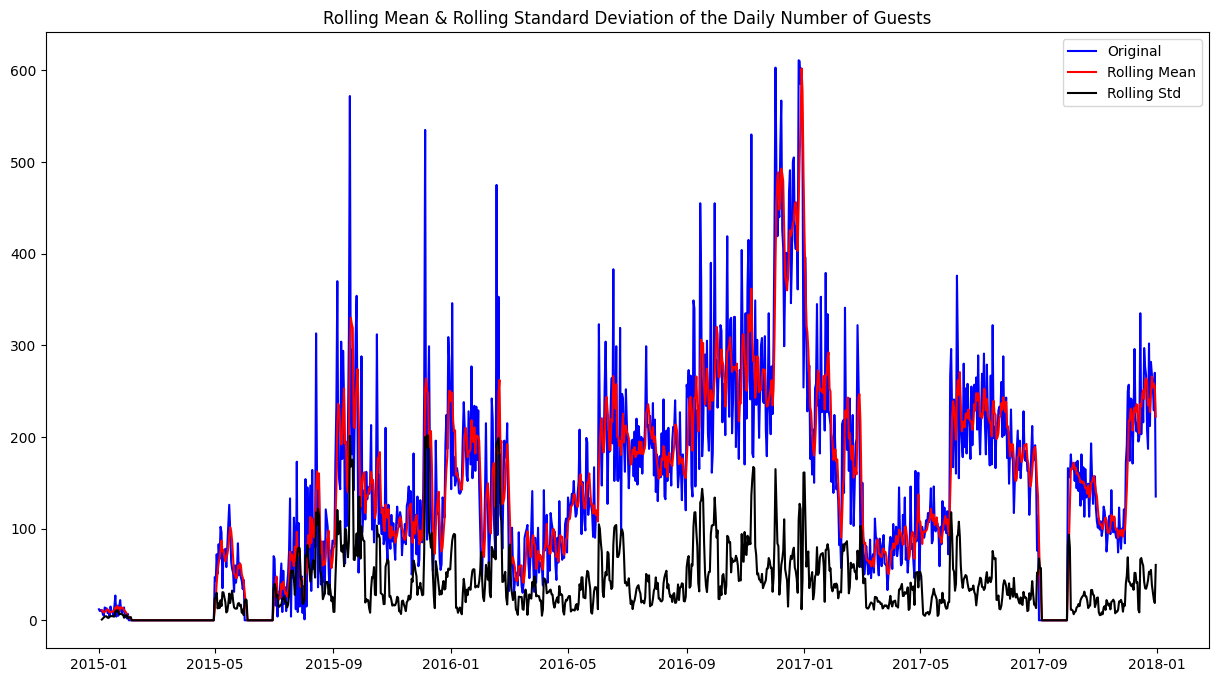

In [75]:
plt.figure(figsize=(15, 8))
rolling_mean = NumberOfGuestsDailyCity.rolling(window=4).mean()
rolling_std = NumberOfGuestsDailyCity.rolling(window=4).std()
plt.plot(NumberOfGuestsDailyCity, color='blue', label='Original')
plt.plot(rolling_mean, color='red', label='Rolling Mean')
plt.plot(rolling_std, color='black', label='Rolling Std')
plt.legend(loc='upper right')
plt.title('Rolling Mean & Rolling Standard Deviation of the Daily Number of Guests')
plt.show()

In [76]:
split_ratio  =  0.8

In [85]:
train_test_split_city_daily = int(len(NumberOfGuestsDailyCity)*split_ratio)
print(f"Split {split_ratio} na train/test, train ima {train_test_split_city_daily} podataka, test {len(NumberOfGuestsDailyCity)-train_test_split_city_daily} podataka")

trainCityDaily = NumberOfGuestsDailyCity[:train_test_split_city_daily]
testCityDaily = NumberOfGuestsDailyCity[train_test_split_city_daily:]

Split 0.8 na train/test, train ima 876 podataka, test 220 podataka


#### Fit ARIMA modela na podatke na dnevnoj bazi

- Iz službene dokumentacije (https://alkaline-ml.com/pmdarima/tips_and_tricks.html#period):
   - The m parameter relates to the number of observations per seasonal cycle, and is one that must be known apriori. Typically, m will correspond to some recurrent periodicity such as:
    - 7 - daily
    - 12 - monthly
    - 52 - weekly

In [86]:
stepwise_fit_daily = auto_arima(trainCityDaily['ukupno_gostiju'], start_p=1, start_q=1,
                          max_p=5, max_q=5, m=7,
                          start_P=0, seasonal=True,
                          d=None, D=1, trace=True,
                          error_action='ignore',
                          suppress_warnings=True,
                          stepwise=True)

stepwise_fit_daily.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[7] intercept   : AIC=9562.274, Time=1.95 sec
 ARIMA(0,0,0)(0,1,0)[7] intercept   : AIC=10097.690, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[7] intercept   : AIC=9851.024, Time=0.55 sec
 ARIMA(0,0,1)(0,1,1)[7] intercept   : AIC=9782.977, Time=0.76 sec
 ARIMA(0,0,0)(0,1,0)[7]             : AIC=10095.754, Time=0.03 sec
 ARIMA(1,0,1)(0,1,0)[7] intercept   : AIC=9967.102, Time=0.31 sec
 ARIMA(1,0,1)(1,1,1)[7] intercept   : AIC=inf, Time=1.28 sec
 ARIMA(1,0,1)(0,1,2)[7] intercept   : AIC=inf, Time=2.24 sec
 ARIMA(1,0,1)(1,1,0)[7] intercept   : AIC=9812.964, Time=0.98 sec
 ARIMA(1,0,1)(1,1,2)[7] intercept   : AIC=inf, Time=4.56 sec
 ARIMA(1,0,0)(0,1,1)[7] intercept   : AIC=9689.723, Time=0.69 sec
 ARIMA(2,0,1)(0,1,1)[7] intercept   : AIC=9565.886, Time=3.14 sec
 ARIMA(1,0,2)(0,1,1)[7] intercept   : AIC=inf, Time=3.00 sec
 ARIMA(0,0,0)(0,1,1)[7] intercept   : AIC=9915.816, Time=0.37 sec
 ARIMA(0,0,2)(0,1,1)[7] intercept   : AIC=9720.974,

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                      y   No. Observations:                  876
Model:             SARIMAX(1, 0, 1)x(1, 1, [1, 2], 7)   Log Likelihood               -4773.159
Date:                                Fri, 16 Feb 2024   AIC                           9558.319
Time:                                        11:29:41   BIC                           9586.923
Sample:                                    01-01-2015   HQIC                          9569.264
                                         - 05-25-2017                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9638      0.010     99.938      0.000       0.945       0.983
ma.L1         -0.6542      0.023    -28.382      0.000      -0.699      -0.609
ar.S.L7       -0.4297      0.285     -1.506      0.132      -0.989       0.129
ma.S.L7       -0.4206      0.276     -1.523      0.128      -0.962       0.121
ma.S.L14      -0.4749      0.251     -1.895      0.058      -0.966       0.016
sigma2      3406.4425     85.785     39.709      0.000    3238.307    3574.578
===================================================================================
Ljung-Box (L1) (Q):                   0.74   Jarque-Bera (JB):              1870.87
Prob(Q):                              0.39   Prob(JB):                         0.00
Heteroskedasticity (H):               2.07   Skew:                             1.37
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

- Bazirano na izlazu auto_arima metode, koristiti ćemo najbolji model 
- ARIMA(1,0,1)(0,1,1)[7] je najbolji model te se to preslikava u parametre
- order = (1,0,1)
- seasonal_order = (1,1,1,7)

In [100]:
modelCity_daily = ARIMA(trainCityDaily['ukupno_gostiju'],
                  order=(1, 0, 1),
                  seasonal_order=(1, 1, 1, 7))

resultCity_daily = modelCity_daily.fit()


##### Predikcije modela na test podacima na dnevnoj bazi

In [101]:
predictionsCityTestDaily = resultCity_daily.predict(train_test_split_city_daily, train_test_split_city_daily + len(testCityDaily) - 1, typ='levels').rename("Predictions")


### Predikcija broja gostija na dnevnoj razini na testnim podacima


Text(0, 0.5, 'Broj gostiju')

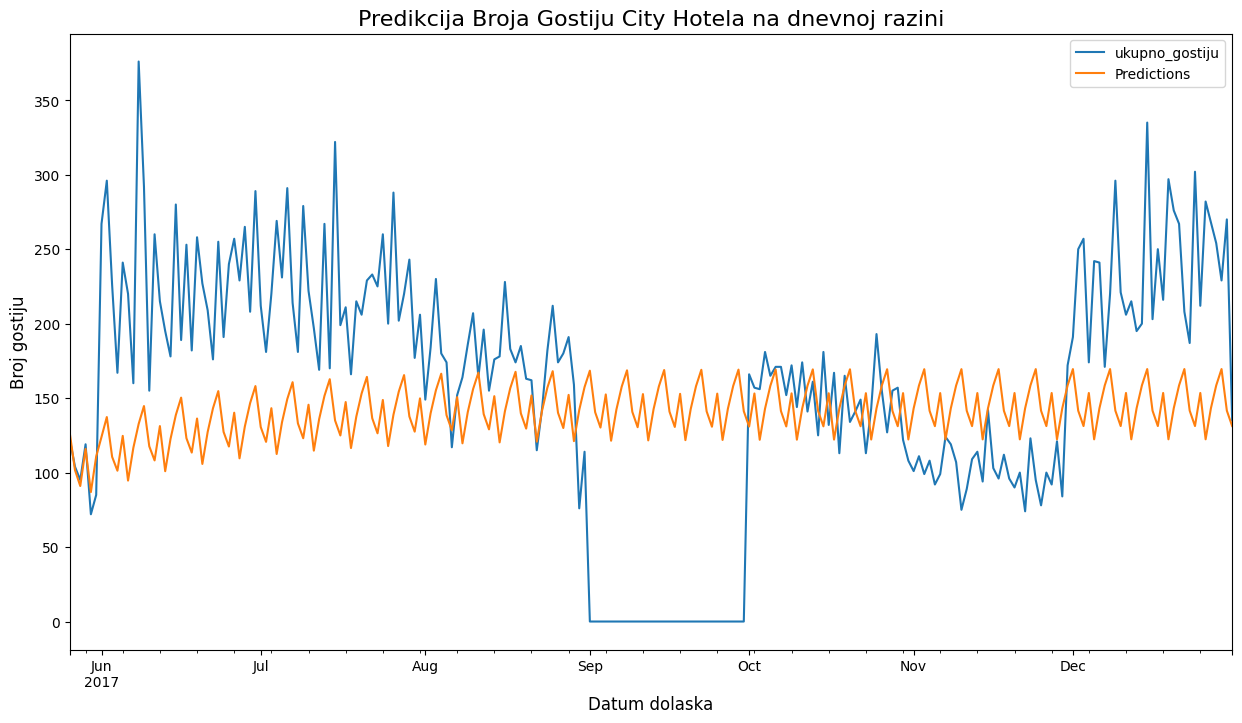

In [102]:
plt.figure(figsize=(15, 8))
testCityDaily['ukupno_gostiju'].plot(legend=True)
predictionsCityTestDaily.plot(legend=True)
plt.title('Predikcija Broja Gostiju City Hotela na dnevnoj razini', fontsize=16)
plt.xlabel('Datum dolaska', fontsize=12)
plt.ylabel('Broj gostiju', fontsize=12)

Text(0, 0.5, 'Broj gostiju')

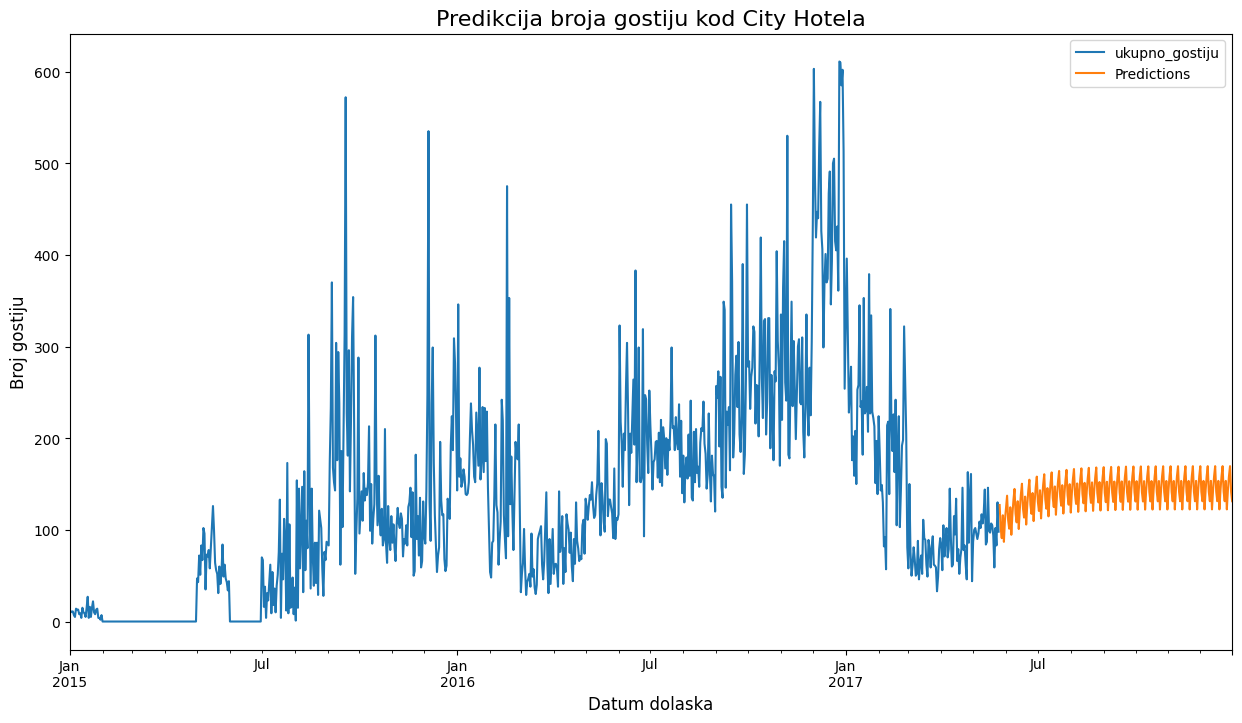

In [103]:
plt.figure(figsize=(15, 8))
trainCityDaily['ukupno_gostiju'].plot(legend=True)
predictionsCityTestDaily.plot(legend=True)
plt.title('Predikcija broja gostiju kod City Hotela', fontsize=16)
plt.xlabel('Datum dolaska', fontsize=12)
plt.ylabel('Broj gostiju', fontsize=12)

In [104]:
MeanAbsPercentageErrCityDaily_test = mean_absolute_percentage_error(testCityDaily, predictionsCityTestDaily)
print('Test MAPE City Hotel na dnevnoj razini: %f' % MeanAbsPercentageErrCityDaily_test)

Test MAPE City Hotel na dnevnoj razini: 89469860224566656.000000


## Predviđanje tjednog broja gostiju 


#### Dickey-Fuller test za podatke o dnevnom broju gostiju

In [94]:
CityWeeklyValues = NumberOfGuestsWeeklyCity.values
result_city = adfuller(CityWeeklyValues)
print('ADF Statistic: %f' % result_city[0])
print('p-value: %f' % result_city[1])
print('Critical Values:')
for key, value in result_city[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.143519
p-value: 0.227379
Critical Values:
	1%: -3.477
	5%: -2.882
	10%: -2.578


- Definirajmo razinu značajnosti alfa=0.05
- Kako je p vrijednost veća od alfe, ne možemo odbaciti H0, odnosno serija je nestacionarna 

#### Rollling Mean i STD City Hotela

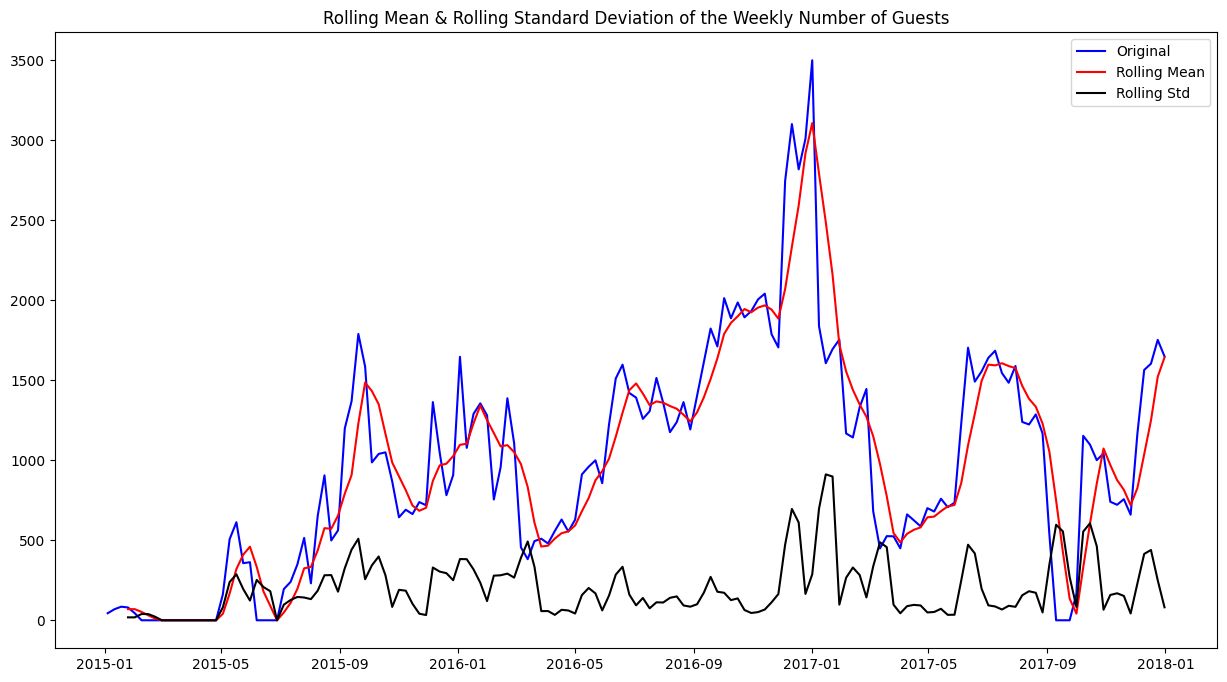

In [62]:
plt.figure(figsize=(15, 8))
rolling_mean = NumberOfGuestsWeeklyCity.rolling(window=4).mean()
rolling_std = NumberOfGuestsWeeklyCity.rolling(window=4).std()
plt.plot(NumberOfGuestsWeeklyCity, color='blue', label='Original')
plt.plot(rolling_mean, color='red', label='Rolling Mean')
plt.plot(rolling_std, color='black', label='Rolling Std')
plt.legend(loc='upper right')
plt.title('Rolling Mean & Rolling Standard Deviation of the Weekly Number of Guests')
plt.show()

In [95]:
split_ratio  =  0.8

In [97]:
train_test_split_city_weekly = int(len(NumberOfGuestsWeeklyCity)*split_ratio)
print(f"Split {split_ratio} na train/test, train ima {train_test_split_city_weekly} podataka, test {len(NumberOfGuestsWeeklyCity)-train_test_split_city_weekly} podataka")

trainCityWeekly = NumberOfGuestsWeeklyCity[:train_test_split_city_weekly]
testCityWeekly = NumberOfGuestsWeeklyCity[train_test_split_city_weekly:]

Split 0.8 na train/test, train ima 125 podataka, test 32 podataka


#### Fit ARIMA modela na podatke na tjednoj bazi

In [126]:
stepwise_fit_weekly = auto_arima(trainCityWeekly['ukupno_gostiju'], start_p=1, start_q=1,
                          max_p=3, max_q=3, m=52,
                          start_P=0, seasonal=True,
                          d=None, D=1, trace=True,
                          error_action='ignore',
                          suppress_warnings=True,
                          stepwise=True)

stepwise_fit_weekly.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[52] intercept   : AIC=1046.830, Time=28.23 sec
 ARIMA(0,0,0)(0,1,0)[52] intercept   : AIC=1139.516, Time=0.24 sec
 ARIMA(1,0,0)(1,1,0)[52] intercept   : AIC=1048.853, Time=6.19 sec
 ARIMA(0,0,1)(0,1,1)[52] intercept   : AIC=1085.148, Time=21.46 sec
 ARIMA(0,0,0)(0,1,0)[52]             : AIC=1206.427, Time=0.10 sec
 ARIMA(1,0,1)(0,1,0)[52] intercept   : AIC=1045.200, Time=1.18 sec
 ARIMA(1,0,1)(1,1,0)[52] intercept   : AIC=1046.755, Time=23.18 sec
 ARIMA(1,0,1)(1,1,1)[52] intercept   : AIC=1048.638, Time=11.63 sec
 ARIMA(0,0,1)(0,1,0)[52] intercept   : AIC=1083.623, Time=0.84 sec
 ARIMA(1,0,0)(0,1,0)[52] intercept   : AIC=1047.091, Time=0.49 sec
 ARIMA(2,0,1)(0,1,0)[52] intercept   : AIC=1046.892, Time=2.15 sec
 ARIMA(1,0,2)(0,1,0)[52] intercept   : AIC=1046.727, Time=1.89 sec
 ARIMA(0,0,2)(0,1,0)[52] intercept   : AIC=1061.387, Time=1.63 sec
 ARIMA(2,0,0)(0,1,0)[52] intercept   : AIC=1046.345, Time=1.18 sec
 ARIMA(2,0,2)(0

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  125
Model:             SARIMAX(1, 0, 1)x(0, 1, [], 52)   Log Likelihood                -518.600
Date:                             Fri, 16 Feb 2024   AIC                           1045.200
Time:                                     12:00:31   BIC                           1054.362
Sample:                                 01-04-2015   HQIC                          1048.851
                                      - 05-21-2017                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    138.6354     98.629      1.406      0.160     -54.674     331.945
ar.L1          0.7971      0.093      8.563      0.000       0.615       0.980
ma.L1          0.3122      0.125      2.490      0.013       0.066       0.558
sigma2      8.498e+04   1.49e+04      5.719      0.000    5.59e+04    1.14e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.30   Jarque-Bera (JB):                 2.68
Prob(Q):                              0.59   Prob(JB):                         0.26
Heteroskedasticity (H):               0.95   Skew:                             0.29
Prob(H) (two-sided):                  0.91   Kurtosis:                         3.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

- Bazirano na izlazu auto_arima metode, koristiti ćemo najbolji model 
- ARIMA(1,0,1)(0,1,0)[52] je najbolji model te se to preslikava u parametre
- order = (1,0,1)
- seasonal_order = (0,1,0,52)

In [127]:
modelCityWeekly = ARIMA(trainCityWeekly['ukupno_gostiju'],
                  order=(1, 0, 1),
                  seasonal_order=(0, 1, 0, 52))

resultCityWeekly = modelCityWeekly.fit()


##### Predikcije modela na test podacima na tjednoj bazi

In [128]:
predictionsCityTestWeekly = resultCityWeekly.predict(train_test_split_city_weekly, train_test_split_city_weekly + len(testCityWeekly) - 1, typ='levels').rename("Predictions")


### Predikcija broja gostija na tjednoj razini na testnim podacima


Text(0, 0.5, 'Broj gostiju')

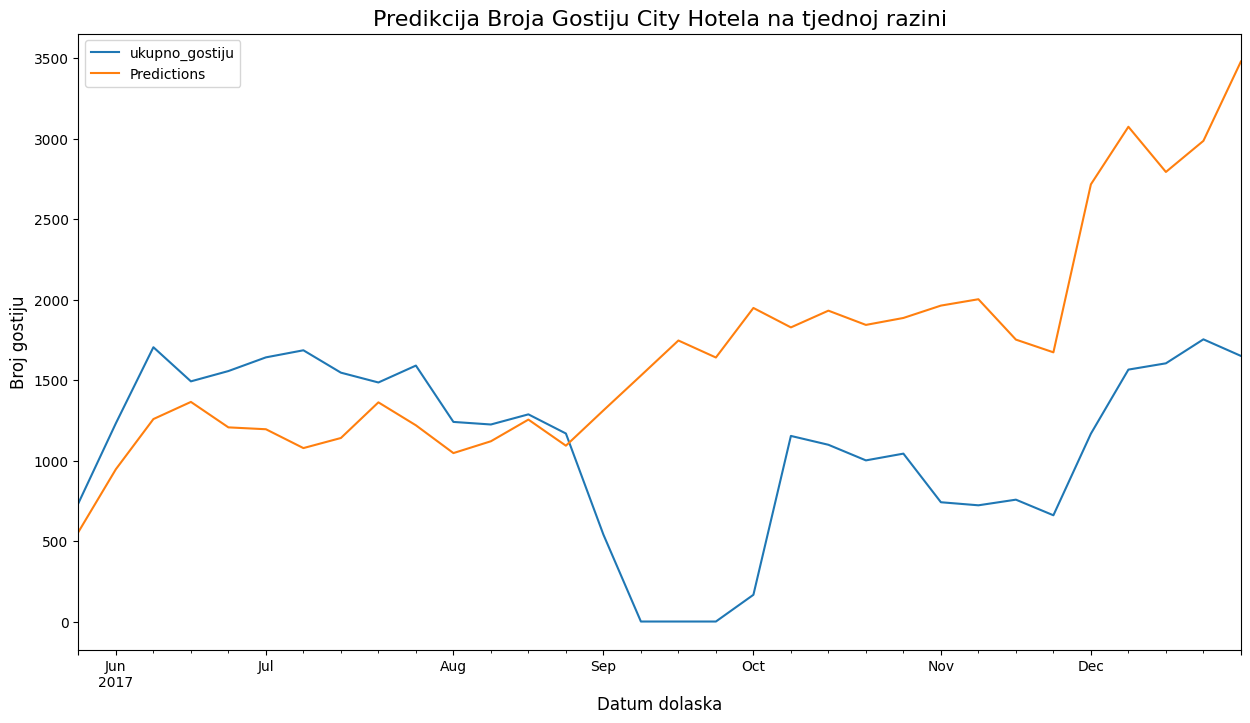

In [129]:
plt.figure(figsize=(15, 8))
testCityWeekly['ukupno_gostiju'].plot(legend=True)
predictionsCityTestWeekly.plot(legend=True)
plt.title('Predikcija Broja Gostiju City Hotela na tjednoj razini', fontsize=16)
plt.xlabel('Datum dolaska', fontsize=12)
plt.ylabel('Broj gostiju', fontsize=12)

### Predikcija broja gostiju na tjednoj razini

Text(0, 0.5, 'Broj gostiju')

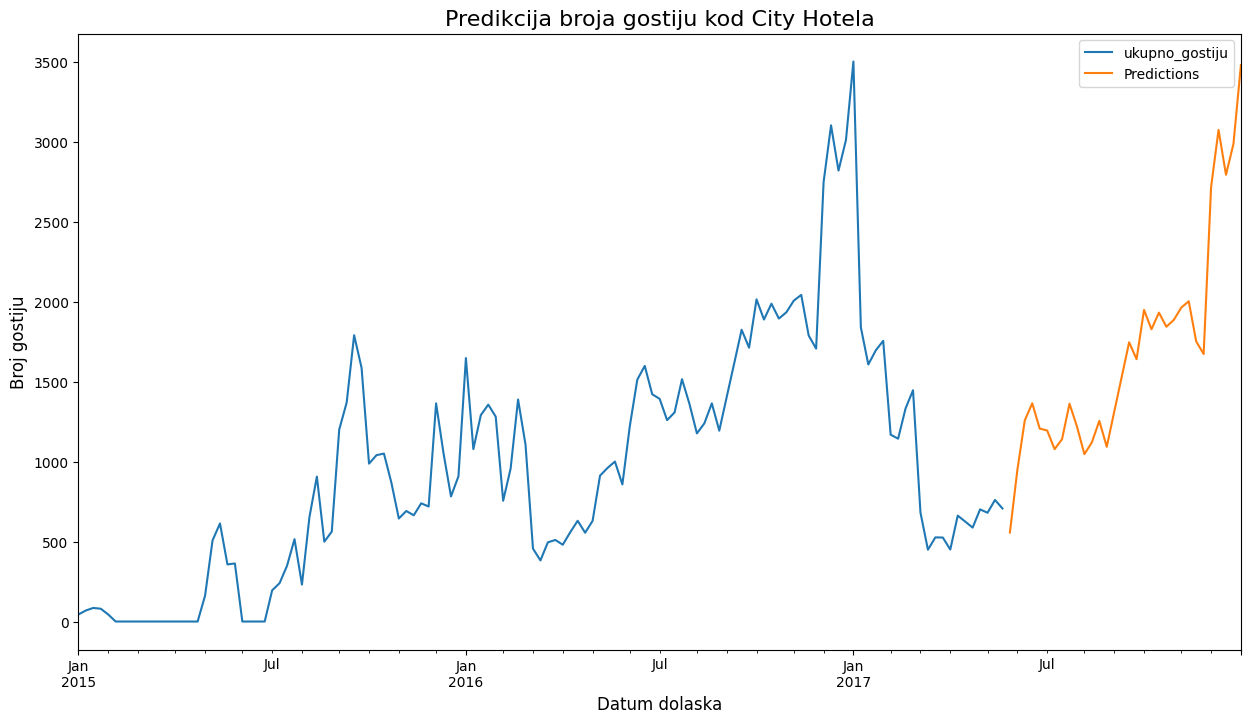

In [130]:
plt.figure(figsize=(15, 8))
trainCityWeekly['ukupno_gostiju'].plot(legend=True)
predictionsCityTestWeekly.plot(legend=True)
plt.title('Predikcija broja gostiju kod City Hotela', fontsize=16)
plt.xlabel('Datum dolaska', fontsize=12)
plt.ylabel('Broj gostiju', fontsize=12)

In [131]:
MeanAbsPercentageErrCityWeekly_test = mean_absolute_percentage_error(testCityWeekly, predictionsCityTestWeekly)
print('Test MAPE City Hotel: %f' % MeanAbsPercentageErrCityWeekly_test)

Test MAPE City Hotel: 691554116344697728.000000


## Predviđanje mjesečnog broja gostiju 


#### Dickey-Fuller test za podatke o mjesečnombroju gostiju

In [132]:
CityMonthlyValues = NumberOfGuestsMonthlyCity.values
result_city = adfuller(CityMonthlyValues)
print('ADF Statistic: %f' % result_city[0])
print('p-value: %f' % result_city[1])
print('Critical Values:')
for key, value in result_city[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.801611
p-value: 0.058044
Critical Values:
	1%: -3.633
	5%: -2.949
	10%: -2.613


- Definirajmo razinu značajnosti alfa=0.05
- Kako je p vrijednost veća od alfe, ne možemo odbaciti H0, odnosno serija je nestacionarna 

#### Rollling Mean i STD City Hotela Mjesečna razina

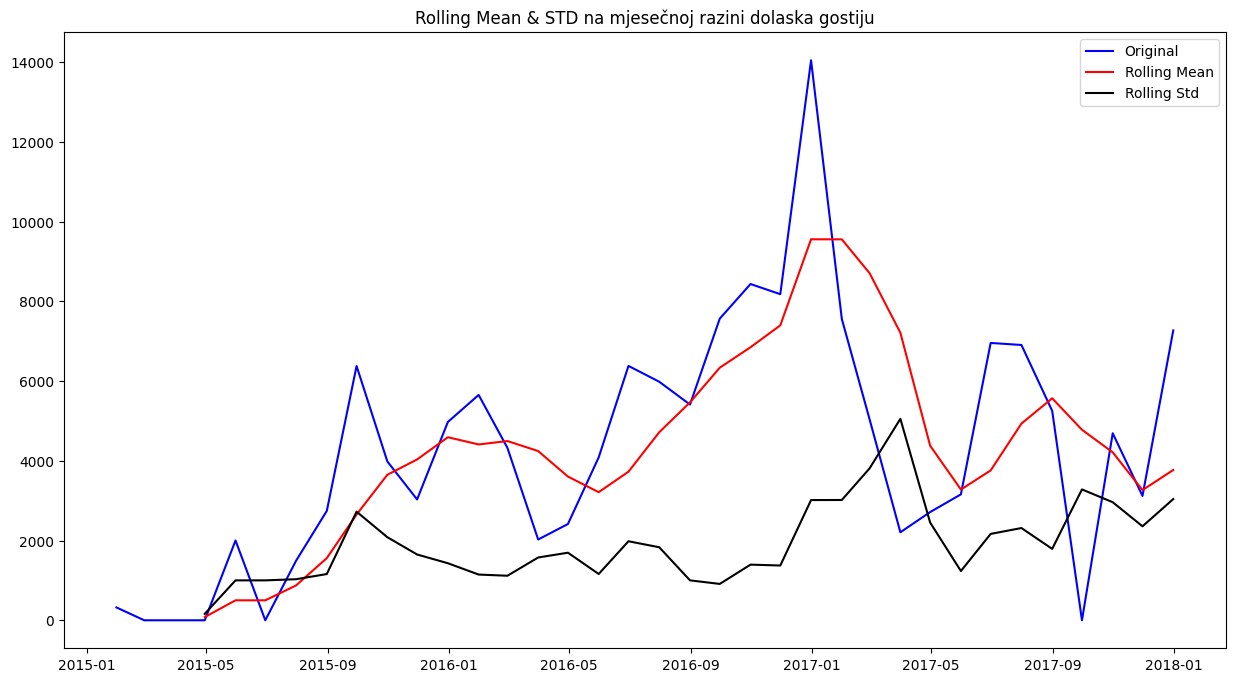

In [133]:
plt.figure(figsize=(15, 8))
rolling_mean = NumberOfGuestsMonthlyCity.rolling(window=4).mean()
rolling_std = NumberOfGuestsMonthlyCity.rolling(window=4).std()
plt.plot(NumberOfGuestsMonthlyCity, color='blue', label='Original')
plt.plot(rolling_mean, color='red', label='Rolling Mean')
plt.plot(rolling_std, color='black', label='Rolling Std')
plt.legend(loc='upper right')
plt.title('Rolling Mean & STD na mjesečnoj razini dolaska gostiju')
plt.show()

In [134]:
split_ratio  =  0.8

In [135]:
train_test_split_city_monthly = int(len(NumberOfGuestsMonthlyCity)*split_ratio)
print(f"Split {split_ratio} na train/test, train ima {train_test_split_city_monthly} podataka, test {len(NumberOfGuestsMonthlyCity)-train_test_split_city_monthly} podataka")

trainCityMonthly = NumberOfGuestsMonthlyCity[:train_test_split_city_monthly]
testCityMonthly = NumberOfGuestsMonthlyCity[train_test_split_city_monthly:]

Split 0.8 na train/test, train ima 28 podataka, test 8 podataka


#### Fit ARIMA modela na podatke na mjesečnoj bazi

In [136]:
stepwise_fit_monthly = auto_arima(trainCityMonthly['ukupno_gostiju'], start_p=1, start_q=1,
                          max_p=3, max_q=3, m=12,
                          start_P=0, seasonal=True,
                          d=None, D=1, trace=True,
                          error_action='ignore',
                          suppress_warnings=True,
                          stepwise=True)

stepwise_fit_monthly.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=301.977, Time=0.11 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=298.133, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=299.706, Time=0.08 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=299.849, Time=0.31 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=313.292, Time=0.01 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=300.077, Time=0.04 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=300.061, Time=0.04 sec
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=302.036, Time=0.06 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=298.123, Time=0.02 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=299.866, Time=0.06 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=301.696, Time=0.13 sec
 ARIMA(2,0,0)(0,1,0)[12] intercept   : AIC=299.037, Time=0.03 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=299.957, Time=0.08 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=298.331, Time=0.03 sec
 ARIMA(2,0,1)(0,1,0)[12] intercep

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   28
Model:             SARIMAX(1, 0, 0)x(0, 1, 0, 12)   Log Likelihood                -146.062
Date:                            Fri, 16 Feb 2024   AIC                            298.123
Time:                                    12:02:43   BIC                            300.441
Sample:                                01-31-2015   HQIC                           298.242
                                     - 04-30-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1976.7812   1244.015      1.589      0.112    -461.443    4415.005
ar.L1          0.3670      0.227      1.616      0.106      -0.078       0.812
sigma2      5.107e+06   2.36e+06      2.166      0.030    4.87e+05    9.73e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                 1.51
Prob(Q):                              0.82   Prob(JB):                         0.47
Heteroskedasticity (H):               8.52   Skew:                             0.75
Prob(H) (two-sided):                  0.03   Kurtosis:                         2.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

- Bazirano na izlazu auto_arima metode, koristiti ćemo najbolji model 
- ARIMA(1,0,0)(0,1,0)[12]  je najbolji model te se to preslikava u parametre
- order = (1,0,0)
- seasonal_order = (0,1,0,12)

In [137]:
modelCityMonthly = ARIMA(trainCityMonthly['ukupno_gostiju'],
                  order=(1, 0, 0),
                  seasonal_order=(0, 1, 0, 12))

resultCityMonthly = modelCityMonthly.fit()


##### Predikcije modela na test podacima na mjesečnoj bazi

In [138]:
predictionsCityTestMonthly = resultCityMonthly.predict(train_test_split_city_monthly, train_test_split_city_monthly + len(testCityMonthly) - 1, typ='levels').rename("Predictions")


### Predikcija broja gostija na mjeečnoj razini na testnim podacima


Text(0, 0.5, 'Broj gostiju')

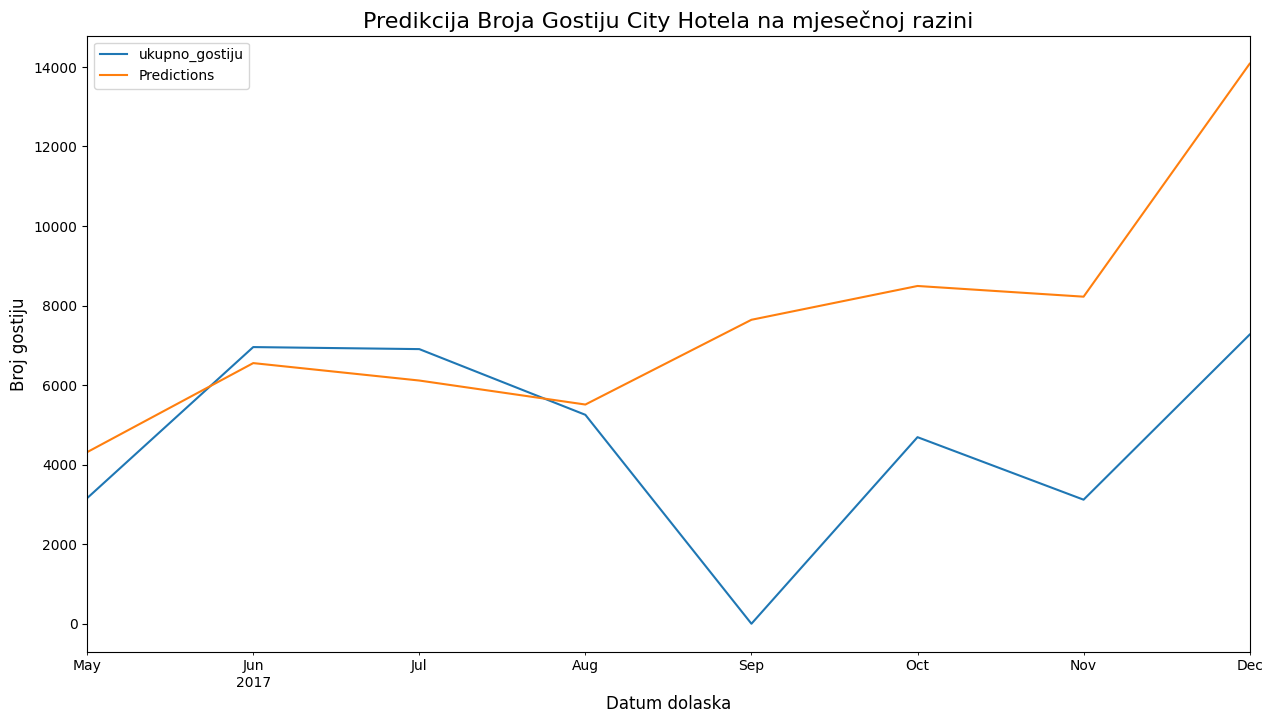

In [142]:
plt.figure(figsize=(15, 8))
testCityMonthly['ukupno_gostiju'].plot(legend=True)
predictionsCityTestMonthly.plot(legend=True)
plt.title('Predikcija Broja Gostiju City Hotela na mjesečnoj razini', fontsize=16)
plt.xlabel('Datum dolaska', fontsize=12)
plt.ylabel('Broj gostiju', fontsize=12)

### Predikcija broja gostiju na mjesečnoj razini

Text(0, 0.5, 'Broj gostiju')

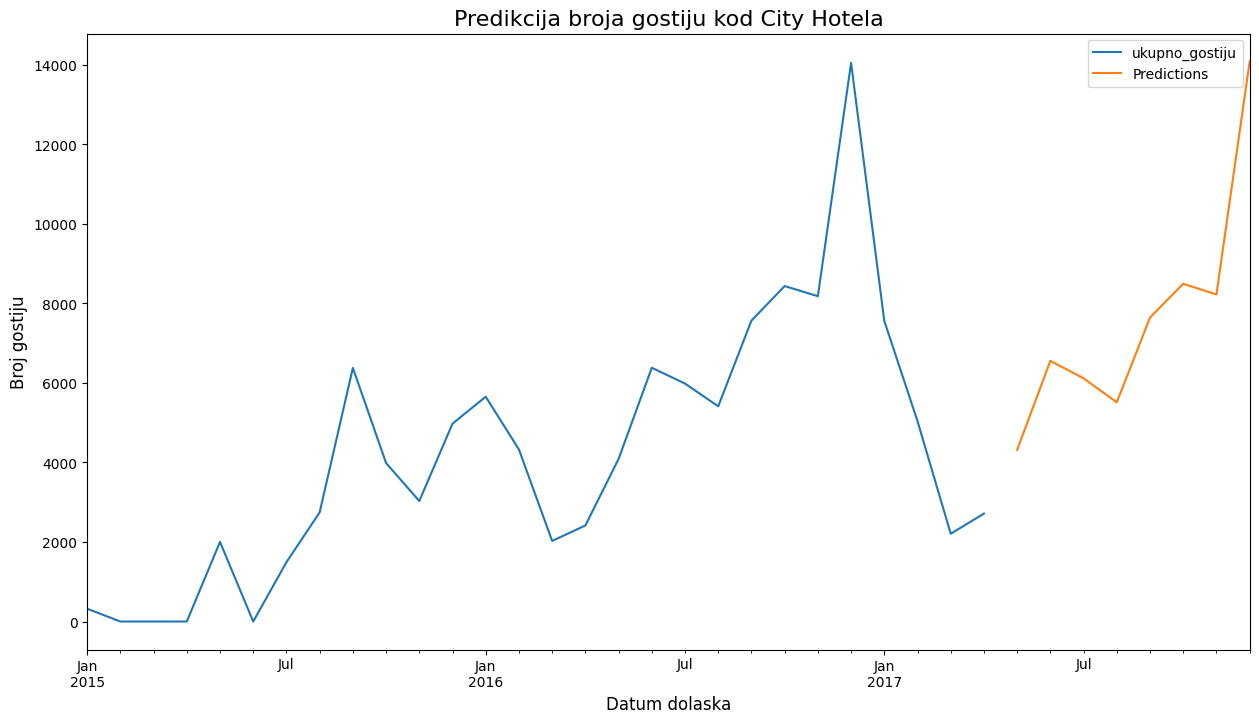

In [140]:
plt.figure(figsize=(15, 8))
trainCityMonthly['ukupno_gostiju'].plot(legend=True)
predictionsCityTestMonthly.plot(legend=True)
plt.title('Predikcija broja gostiju kod City Hotela', fontsize=16)
plt.xlabel('Datum dolaska', fontsize=12)
plt.ylabel('Broj gostiju', fontsize=12)

In [141]:
MeanAbsPercentageErrCityMonthly_test = mean_absolute_percentage_error(testCityMonthly, predictionsCityTestMonthly)
print('Test MAPE City Hotel: %f' % MeanAbsPercentageErrCityMonthly_test)

Test MAPE City Hotel: 4302303038436769792.000000


# ARIMA model za predviđanje budućeg broja gostiju - Resort Hotel 


## Predviđanje dnevnog broja gostiju 


#### Dickey-Fuller test za podatke o dnevnom broju gostiju

In [158]:
ResortDailyValues = NumberOfGuestsDailyResort.values
result_resort = adfuller(ResortDailyValues)
print('ADF Statistic: %f' % result_resort[0])
print('p-value: %f' % result_resort[1])
print('Critical Values:')
for key, value in result_resort[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -4.011804
p-value: 0.001350
Critical Values:
	1%: -3.439
	5%: -2.865
	10%: -2.569


- Definirajmo razinu značajnosti alfa=0.05
- Kako je p vrijednost manja od alfe,  možemo odbaciti H0, odnosno serija je stacionarna 

#### Rollling Mean i STD Resort Hotela na dnevnioj razini

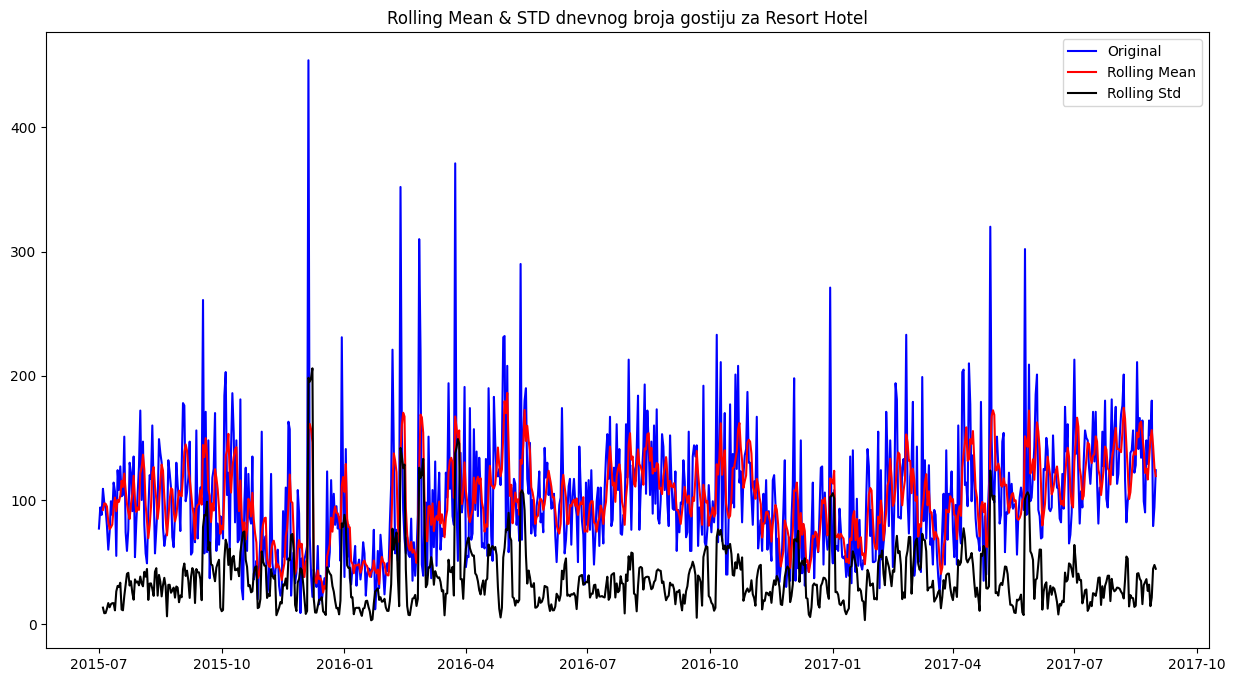

In [161]:
plt.figure(figsize=(15, 8))
rolling_mean = NumberOfGuestsDailyResort.rolling(window=4).mean()
rolling_std = NumberOfGuestsDailyResort.rolling(window=4).std()
plt.plot(NumberOfGuestsDailyResort, color='blue', label='Original')
plt.plot(rolling_mean, color='red', label='Rolling Mean')
plt.plot(rolling_std, color='black', label='Rolling Std')
plt.legend(loc='upper right')
plt.title('Rolling Mean & STD dnevnog broja gostiju za Resort Hotel')
plt.show()

In [162]:
split_ratio  =  0.8

In [163]:
train_test_split_resort_daily = int(len(NumberOfGuestsDailyResort)*split_ratio)
print(f"Split {split_ratio} na train/test, train ima {train_test_split_resort_daily} podataka, test {len(NumberOfGuestsDailyResort)-train_test_split_resort_daily} podataka")

trainResortDaily = NumberOfGuestsDailyResort[:train_test_split_resort_daily]
testResortDaily = NumberOfGuestsDailyResort[train_test_split_resort_daily:]

Split 0.8 na train/test, train ima 634 podataka, test 159 podataka


#### Fit ARIMA modela na podatke na dnevnoj bazi

In [177]:
stepwise_fit_resort_daily = auto_arima(trainResortDaily['ukupno_gostiju'], start_p=1, start_q=1,
                          max_p=3, max_q=3, m=7,
                          start_P=0, seasonal=True,
                          d=0, D=1, trace=True,
                          error_action='ignore',
                          suppress_warnings=True,
                          stepwise=True)

stepwise_fit_resort_daily.summary()

Performing stepwise search to minimize aic


 ARIMA(1,0,1)(0,1,1)[7] intercept   : AIC=inf, Time=3.21 sec
 ARIMA(0,0,0)(0,1,0)[7] intercept   : AIC=6925.426, Time=0.05 sec
 ARIMA(1,0,0)(1,1,0)[7] intercept   : AIC=6741.060, Time=0.66 sec
 ARIMA(0,0,1)(0,1,1)[7] intercept   : AIC=6627.105, Time=1.02 sec
 ARIMA(0,0,0)(0,1,0)[7]             : AIC=6923.444, Time=0.04 sec
 ARIMA(0,0,1)(0,1,0)[7] intercept   : AIC=6916.749, Time=0.33 sec
 ARIMA(0,0,1)(1,1,1)[7] intercept   : AIC=inf, Time=1.23 sec
 ARIMA(0,0,1)(0,1,2)[7] intercept   : AIC=inf, Time=2.22 sec
 ARIMA(0,0,1)(1,1,0)[7] intercept   : AIC=6741.353, Time=0.61 sec
 ARIMA(0,0,1)(1,1,2)[7] intercept   : AIC=inf, Time=5.15 sec
 ARIMA(0,0,0)(0,1,1)[7] intercept   : AIC=6643.224, Time=0.54 sec
 ARIMA(0,0,2)(0,1,1)[7] intercept   : AIC=6627.645, Time=1.56 sec
 ARIMA(1,0,0)(0,1,1)[7] intercept   : AIC=6624.995, Time=1.10 sec
 ARIMA(1,0,0)(0,1,0)[7] intercept   : AIC=6916.325, Time=0.14 sec
 ARIMA(1,0,0)(1,1,1)[7] intercept   : AIC=inf, Time=1.22 sec
 ARIMA(1,0,0)(0,1,2)[7] intercept  

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  634
Model:             SARIMAX(2, 0, 0)x(0, 1, [1], 7)   Log Likelihood               -3307.425
Date:                             Fri, 16 Feb 2024   AIC                           6622.850
Time:                                     15:10:12   BIC                           6640.614
Sample:                                 07-01-2015   HQIC                          6629.752
                                      - 03-25-2017                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1752      0.036      4.890      0.000       0.105       0.245
ar.L2          0.0606      0.038      1.583      0.113      -0.014       0.136
ma.S.L7       -0.8812      0.021    -42.769      0.000      -0.922      -0.841
sigma2      2198.1250     53.073     41.417      0.000    2094.104    2302.146
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):              2743.99
Prob(Q):                              0.85   Prob(JB):                         0.00
Heteroskedasticity (H):               0.85   Skew:                             1.93
Prob(H) (two-sided):                  0.25   Kurtosis:                        12.49
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

- Bazirano na izlazu auto_arima metode, koristiti ćemo najbolji model 
- ARIMA(2,0,0)(0,1,1)[7]    je najbolji model te se to preslikava u parametre
- order = (2, 0 ,0)
- seasonal_order = (0,1,1,7)


In [178]:
modelResort_daily = ARIMA(trainResortDaily['ukupno_gostiju'],
                  order=(2, 0, 0),
                  seasonal_order=(0, 1, 1, 7))

resultResort_daily = modelResort_daily.fit()


##### Predikcije modela na test podacima na dnevnoj bazi

In [179]:
predictionsResortTestDaily = resultResort_daily.predict(train_test_split_resort_daily, train_test_split_resort_daily + len(testResortDaily) - 1, typ='levels').rename("Predictions")


### Predikcija broja gostija na dnevnoj razini na testnim podacima


Text(0, 0.5, 'Broj gostiju')

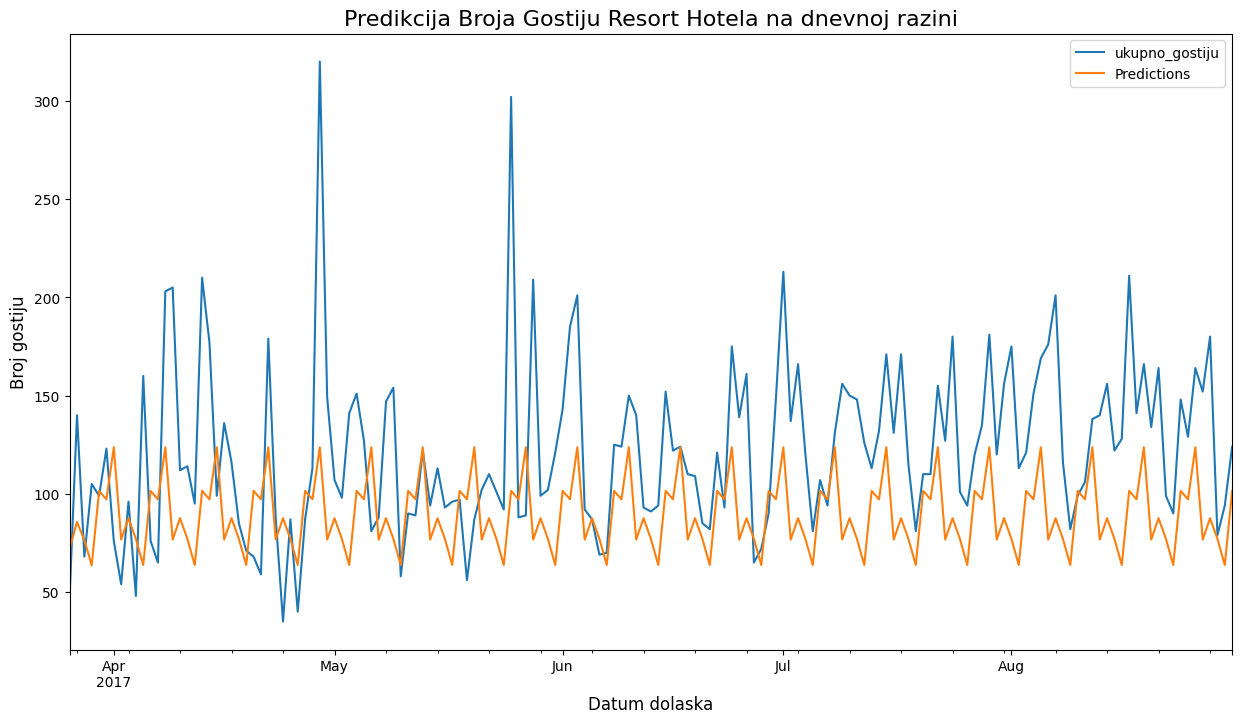

In [180]:
plt.figure(figsize=(15, 8))
testResortDaily['ukupno_gostiju'].plot(legend=True)
predictionsResortTestDaily.plot(legend=True)
plt.title('Predikcija Broja Gostiju Resort Hotela na dnevnoj razini', fontsize=16)
plt.xlabel('Datum dolaska', fontsize=12)
plt.ylabel('Broj gostiju', fontsize=12)

Text(0, 0.5, 'Broj gostiju')

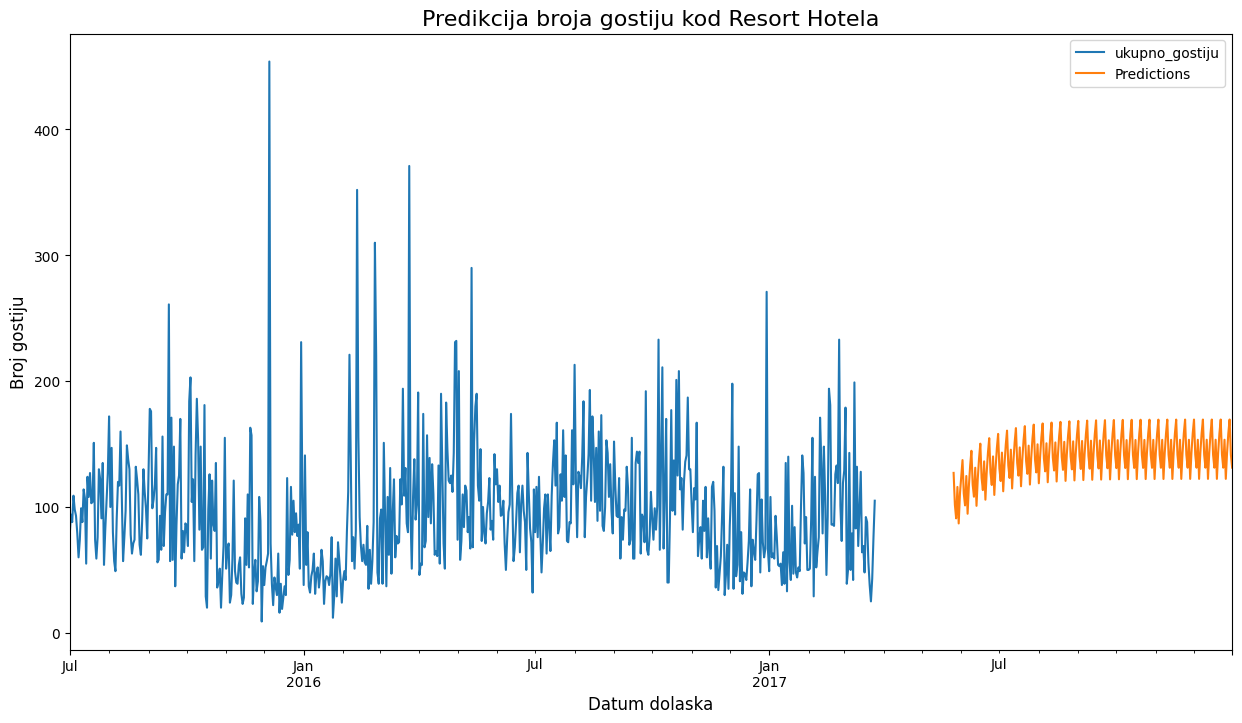

In [181]:
plt.figure(figsize=(15, 8))
trainResortDaily['ukupno_gostiju'].plot(legend=True)
predictionsCityTestDaily.plot(legend=True)
plt.title('Predikcija dnevnog broja gostiju kod Resort Hotela', fontsize=16)
plt.xlabel('Datum dolaska', fontsize=12)
plt.ylabel('Broj gostiju', fontsize=12)

In [182]:
MeanAbsPercentageErrCityDaily_test = mean_absolute_percentage_error(testCityDaily, predictionsCityTestDaily)
print('Test MAPE City Hotel na dnevnoj razini: %f' % MeanAbsPercentageErrCityDaily_test)

Test MAPE City Hotel na dnevnoj razini: 89469860224566656.000000


## Predviđanje tjednog broja gostiju 


#### Dickey-Fuller test za podatke o tjednom broju gostiju

In [184]:
ResortWeeklyValues = NumberOfGuestsWeeklyResort.values
result_resort = adfuller(ResortWeeklyValues)
print('ADF Statistic: %f' % result_resort[0])
print('p-value: %f' % result_resort[1])
print('Critical Values:')
for key, value in result_resort[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -4.110674
p-value: 0.000930
Critical Values:
	1%: -3.490
	5%: -2.888
	10%: -2.581


- Definirajmo razinu značajnosti alfa=0.05
- Kako je p vrijednost manja od alfe,  možemo odbaciti H0, odnosno serija je stacionarna 

#### Rollling Mean i STD Resort Hotela na tjednoj razini

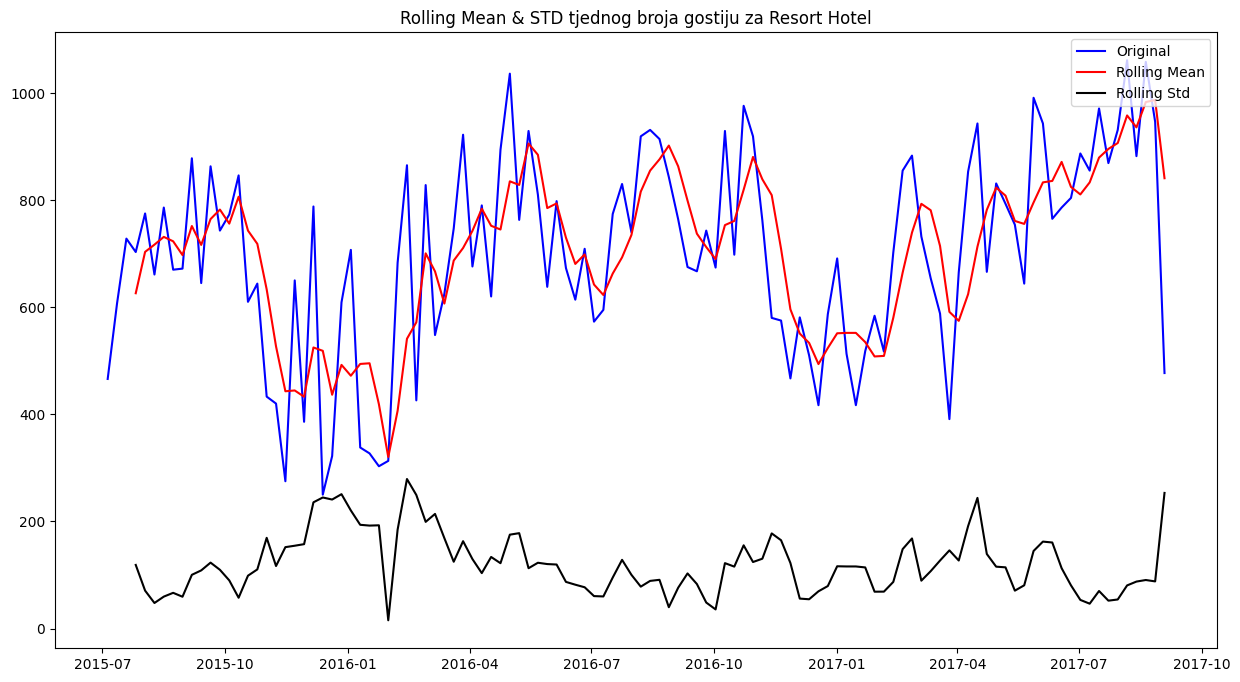

In [186]:
plt.figure(figsize=(15, 8))
rolling_mean = NumberOfGuestsWeeklyResort.rolling(window=4).mean()
rolling_std = NumberOfGuestsWeeklyResort.rolling(window=4).std()
plt.plot(NumberOfGuestsWeeklyResort, color='blue', label='Original')
plt.plot(rolling_mean, color='red', label='Rolling Mean')
plt.plot(rolling_std, color='black', label='Rolling Std')
plt.legend(loc='upper right')
plt.title('Rolling Mean & STD tjednog broja gostiju za Resort Hotel')
plt.show()

In [187]:
split_ratio  =  0.8

In [189]:
train_test_split_resort_weekly = int(len(NumberOfGuestsWeeklyResort)*split_ratio)
print(f"Split {split_ratio} na train/test, train ima {train_test_split_resort_weekly} podataka, test {len(NumberOfGuestsWeeklyResort)-train_test_split_resort_weekly} podataka")

trainResortWeekly = NumberOfGuestsWeeklyResort[:train_test_split_resort_weekly]
testResortWeekly = NumberOfGuestsWeeklyResort[train_test_split_resort_weekly:]

Split 0.8 na train/test, train ima 91 podataka, test 23 podataka


#### Fit ARIMA modela na podatke na tjednoj bazi

In [191]:
stepwise_fit_resort_weekly = auto_arima(trainResortWeekly['ukupno_gostiju'], 
                          start_p=1, start_q=1,
                          max_p=3, max_q=3, m=54,
                          start_P=0, seasonal=True,
                          d=0, D=1, trace=True,
                          error_action='ignore',
                          suppress_warnings=True,
                          stepwise=True)

stepwise_fit_resort_weekly.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[54] intercept   : AIC=inf, Time=51.84 sec
 ARIMA(0,0,0)(0,1,0)[54] intercept   : AIC=497.213, Time=0.24 sec
 ARIMA(1,0,0)(1,1,0)[54] intercept   : AIC=inf, Time=44.34 sec
 ARIMA(0,0,1)(0,1,1)[54] intercept   : AIC=inf, Time=36.25 sec
 ARIMA(0,0,0)(0,1,0)[54]             : AIC=502.814, Time=0.22 sec
 ARIMA(0,0,0)(1,1,0)[54] intercept   : AIC=inf, Time=37.15 sec
 ARIMA(0,0,0)(0,1,1)[54] intercept   : AIC=inf, Time=19.77 sec
 ARIMA(0,0,0)(1,1,1)[54] intercept   : AIC=inf, Time=44.22 sec
 ARIMA(1,0,0)(0,1,0)[54] intercept   : AIC=499.199, Time=1.30 sec
 ARIMA(0,0,1)(0,1,0)[54] intercept   : AIC=499.199, Time=1.15 sec
 ARIMA(1,0,1)(0,1,0)[54] intercept   : AIC=501.198, Time=1.26 sec

Best model:  ARIMA(0,0,0)(0,1,0)[54] intercept
Total fit time: 237.759 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                 
================================================================================
Dep. Variable:                        y   No. Observations:                   91
Model:             SARIMAX(0, 1, 0, 54)   Log Likelihood                -246.606
Date:                  Fri, 16 Feb 2024   AIC                            497.213
Time:                          15:21:23   BIC                            500.435
Sample:                      07-05-2015   HQIC                           498.349
                           - 03-26-2017                                         
Covariance Type:                    opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     90.6486     35.888      2.526      0.012      20.309     160.989
sigma2      3.603e+04   1.07e+04      3.378      0.001    1.51e+04    5.69e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 2.66
Prob(Q):                              0.89   Prob(JB):                         0.26
Heteroskedasticity (H):               1.88   Skew:                            -0.63
Prob(H) (two-sided):                  0.29   Kurtosis:                         2.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

- Bazirano na izlazu auto_arima metode, koristiti ćemo najbolji model 
- ARIMA(0,0,0)(0,1,0)[54]    je najbolji model te se to preslikava u parametre
- order = (0,0,0)
- seasonal_order = (0,1,0)[54] 


In [192]:
modelResort_weekly = ARIMA(trainResortWeekly['ukupno_gostiju'],
                  order=(0, 0, 0),
                  seasonal_order=(0, 1, 0, 54))

resultResort_weekly= modelResort_weekly.fit()


##### Predikcije modela na test podacima na tjednoj bazi

In [193]:
predictionsResortTestWeekly = resultResort_weekly.predict(train_test_split_resort_weekly, train_test_split_resort_weekly + len(testResortWeekly) - 1, typ='levels').rename("Predictions")


### Predikcija broja gostija na tjednoj razini na testnim podacima


Text(0, 0.5, 'Broj gostiju')

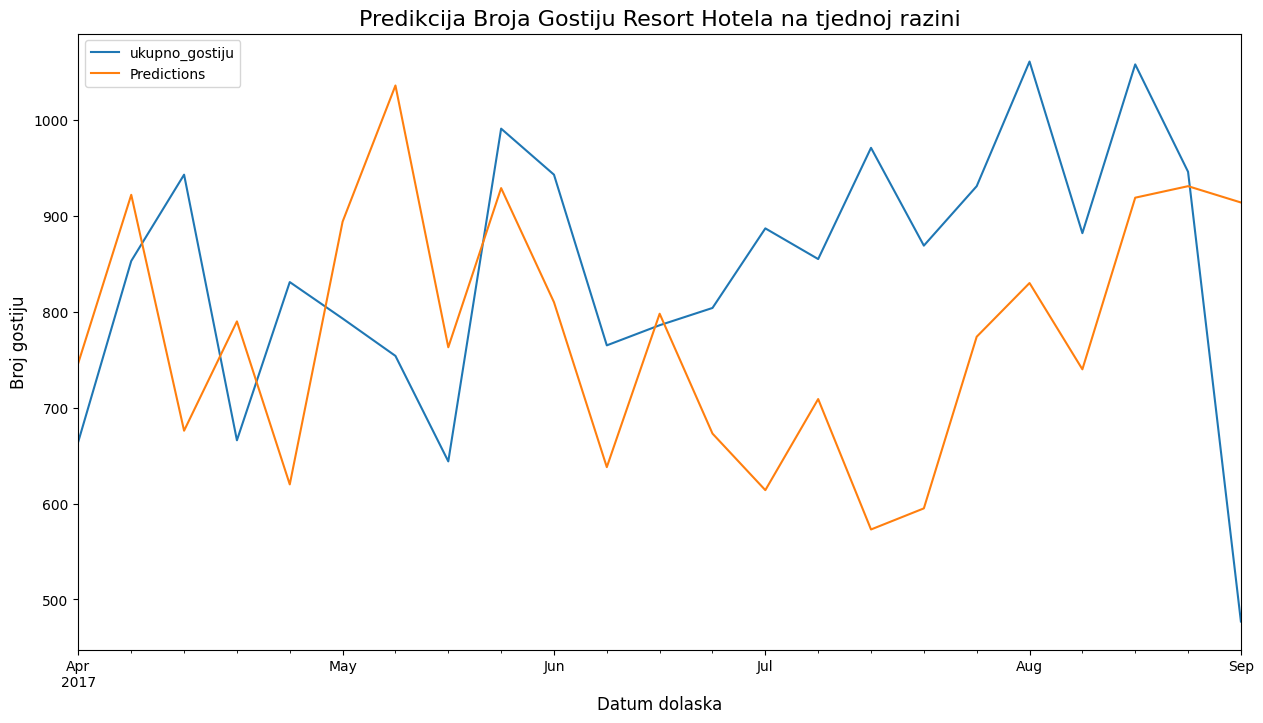

In [194]:
plt.figure(figsize=(15, 8))
testResortWeekly['ukupno_gostiju'].plot(legend=True)
predictionsResortTestWeekly.plot(legend=True)
plt.title('Predikcija Broja Gostiju Resort Hotela na tjednoj razini', fontsize=16)
plt.xlabel('Datum dolaska', fontsize=12)
plt.ylabel('Broj gostiju', fontsize=12)

Text(0, 0.5, 'Broj gostiju')

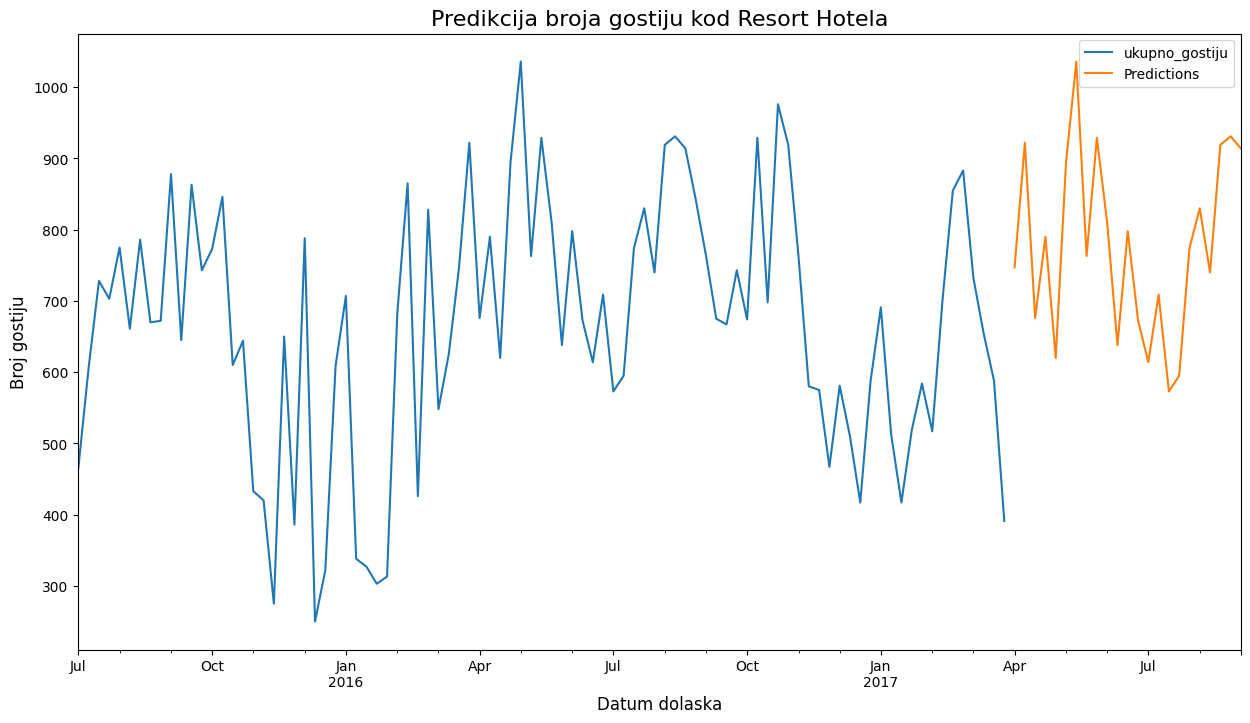

In [195]:
plt.figure(figsize=(15, 8))
trainResortWeekly['ukupno_gostiju'].plot(legend=True)
predictionsResortTestWeekly.plot(legend=True)
plt.title('Predikcija broja gostiju kod Resort Hotela', fontsize=16)
plt.xlabel('Datum dolaska', fontsize=12)
plt.ylabel('Broj gostiju', fontsize=12)

In [196]:
MeanAbsPercentageErrResortWeekly_test = mean_absolute_percentage_error(testResortWeekly, predictionsResortTestWeekly)
print('Test MAPE Resort Hotel na tjednoj razini: %f' % MeanAbsPercentageErrResortWeekly_test)

Test MAPE Resort Hotel na tjednoj razini: 0.216342


## Predviđanje mjesečnog broja gostiju 


#### Dickey-Fuller test za podatke o mjesečnom broju gostiju

In [199]:
ResortMonthlyValues = NumberOfGuestsMonthlyResort.values
result_resort = adfuller(ResortMonthlyValues)
print('ADF Statistic: %f' % result_resort[0])
print('p-value: %f' % result_resort[1])
print('Critical Values:')
for key, value in result_resort[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.494698
p-value: 0.116770
Critical Values:
	1%: -3.724
	5%: -2.986
	10%: -2.633


- Definirajmo razinu značajnosti alfa=0.05
- Kako je p vrijednost veća od alfe, ne možemo odbaciti H0, odnosno serija nije stacionarna 

#### Rollling Mean i STD Resort Hotela na mjesečnoj razini

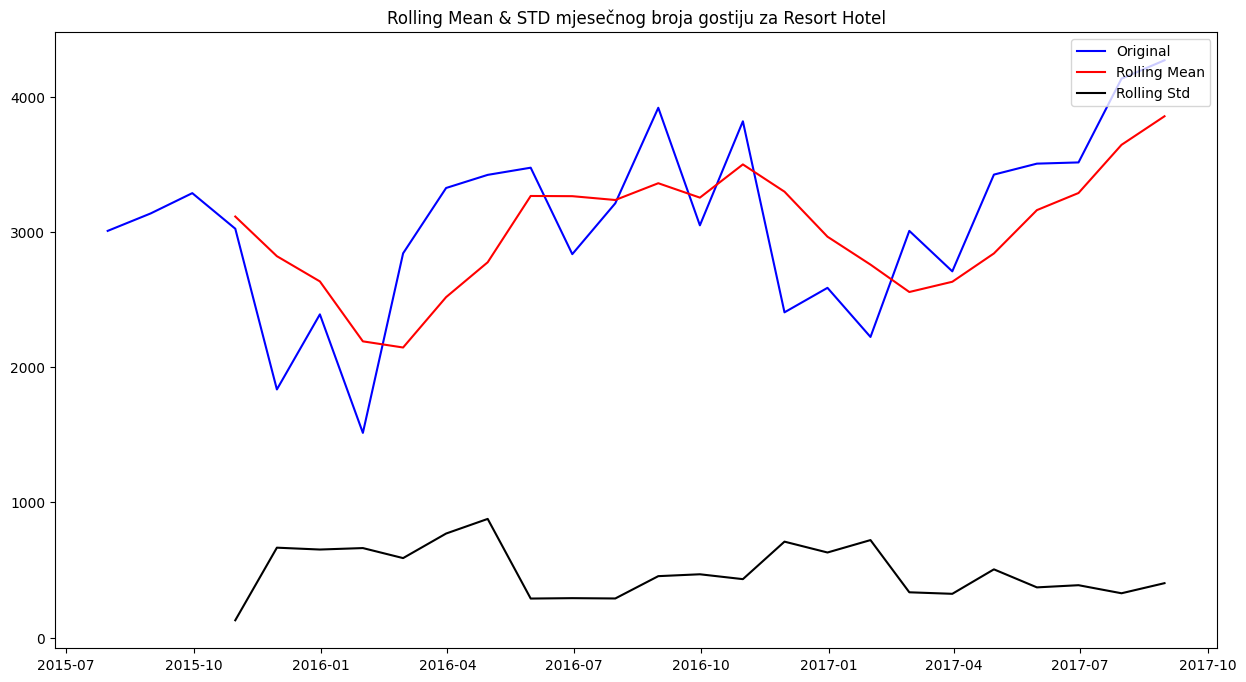

In [200]:
plt.figure(figsize=(15, 8))
rolling_mean = NumberOfGuestsMonthlyResort.rolling(window=4).mean()
rolling_std = NumberOfGuestsMonthlyResort.rolling(window=4).std()
plt.plot(NumberOfGuestsMonthlyResort, color='blue', label='Original')
plt.plot(rolling_mean, color='red', label='Rolling Mean')
plt.plot(rolling_std, color='black', label='Rolling Std')
plt.legend(loc='upper right')
plt.title('Rolling Mean & STD mjesečnog broja gostiju za Resort Hotel')
plt.show()

In [ ]:
split_ratio  =  0.8

In [201]:
train_test_split_resort_monthly = int(len(NumberOfGuestsMonthlyResort)*split_ratio)
print(f"Split {split_ratio} na train/test, train ima {train_test_split_resort_monthly} podataka, test {len(NumberOfGuestsMonthlyResort)-train_test_split_resort_monthly} podataka")

trainResortMonthly = NumberOfGuestsMonthlyResort[:train_test_split_resort_monthly]
testResortMonthly = NumberOfGuestsMonthlyResort[train_test_split_resort_monthly:]

Split 0.8 na train/test, train ima 20 podataka, test 6 podataka


In [202]:
stepwise_fit_resort_monthly = auto_arima(trainResortMonthly['ukupno_gostiju'], 
                          start_p=1, start_q=1,
                          max_p=3, max_q=3, m=12,
                          start_P=0, seasonal=True,
                          d=None, D=1, trace=True,
                          error_action='ignore',
                          suppress_warnings=True,
                          stepwise=True)

stepwise_fit_resort_monthly.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.47 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=120.320, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=118.362, Time=0.19 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.40 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=125.016, Time=0.01 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=116.411, Time=0.04 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=inf, Time=0.37 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.54 sec
 ARIMA(2,0,0)(0,1,0)[12] intercept   : AIC=115.845, Time=0.08 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=117.839, Time=0.30 sec
 ARIMA(2,0,0)(0,1,1)[12] intercept   : AIC=inf, Time=0.45 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.61 sec
 ARIMA(3,0,0)(0,1,0)[12] intercept   : AIC=117.676, Time=0.28 sec
 ARIMA(2,0,1)(0,1,0)[12] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=inf, Time=0.13 sec

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   20
Model:             SARIMAX(2, 0, 0)x(0, 1, 0, 12)   Log Likelihood                 -53.922
Date:                            Fri, 16 Feb 2024   AIC                            115.845
Time:                                    15:50:44   BIC                            116.163
Sample:                                07-31-2015   HQIC                           113.702
                                     - 02-28-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1095.1824    327.247      3.347      0.001     453.790    1736.575
ar.L1         -1.0822      0.454     -2.383      0.017      -1.972      -0.192
ar.L2         -0.5404      0.390     -1.387      0.165      -1.304       0.223
sigma2      3.672e+04   4.18e+04      0.878      0.380   -4.53e+04    1.19e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                 0.81
Prob(Q):                              0.83   Prob(JB):                         0.67
Heteroskedasticity (H):               0.23   Skew:                            -0.73
Prob(H) (two-sided):                  0.26   Kurtosis:                         2.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

- Bazirano na izlazu auto_arima metode, koristiti ćemo najbolji model 
- ARIMA(2,0,0)(0,1,0)[12]   je najbolji model te se to preslikava u parametre
- order = (2,0,0)
- seasonal_order = (0,1,0)[12] 


In [203]:
modelResort_monthly = ARIMA(trainResortMonthly['ukupno_gostiju'],
                  order=(2, 0, 0),
                  seasonal_order=(0, 1, 0, 12))

resultResort_monthly= modelResort_monthly.fit()


##### Predikcije modela na test podacima na mjesečnoj bazi

In [204]:
predictionsResortTestMonthly = resultResort_monthly.predict(train_test_split_resort_monthly, train_test_split_resort_monthly + len(testResortMonthly) - 1, typ='levels').rename("Predictions")


### Predikcija broja gostija na mjesečnoj razini na testnim podacima


Text(0, 0.5, 'Broj gostiju')

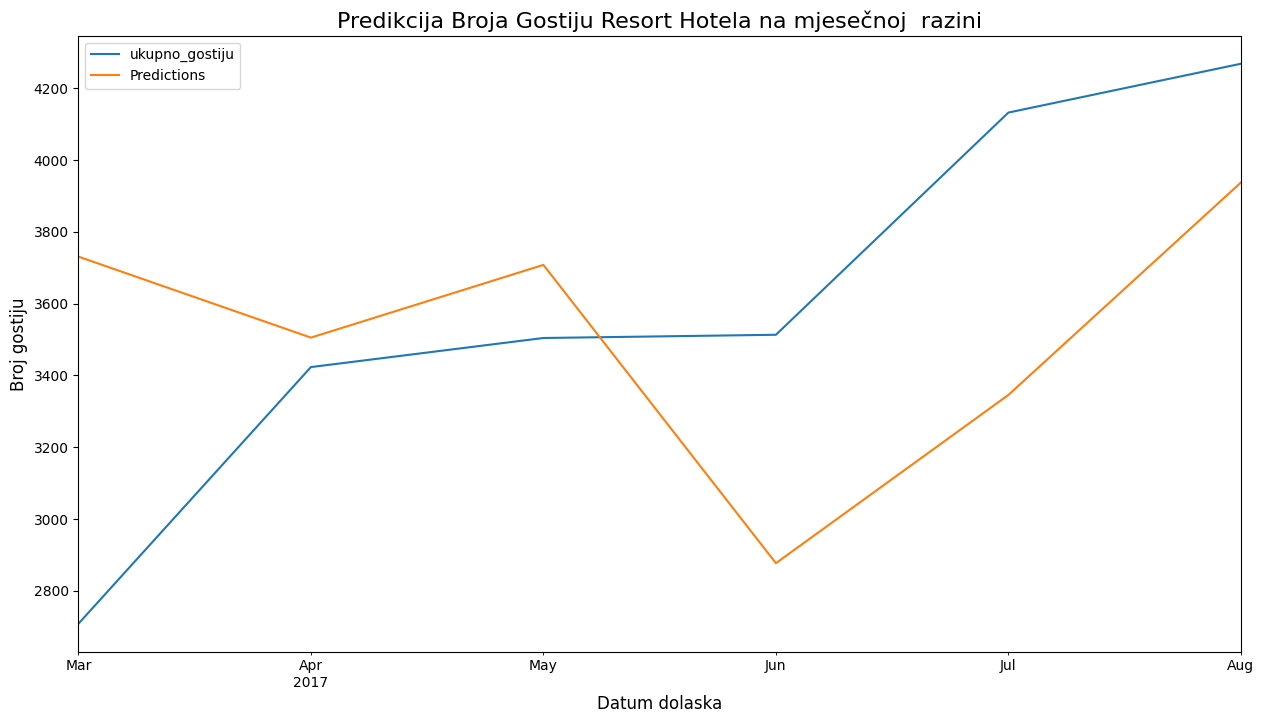

In [205]:
plt.figure(figsize=(15, 8))
testResortMonthly['ukupno_gostiju'].plot(legend=True)
predictionsResortTestMonthly.plot(legend=True)
plt.title('Predikcija Broja Gostiju Resort Hotela na mjesečnoj  razini', fontsize=16)
plt.xlabel('Datum dolaska', fontsize=12)
plt.ylabel('Broj gostiju', fontsize=12)

Text(0, 0.5, 'Broj gostiju')

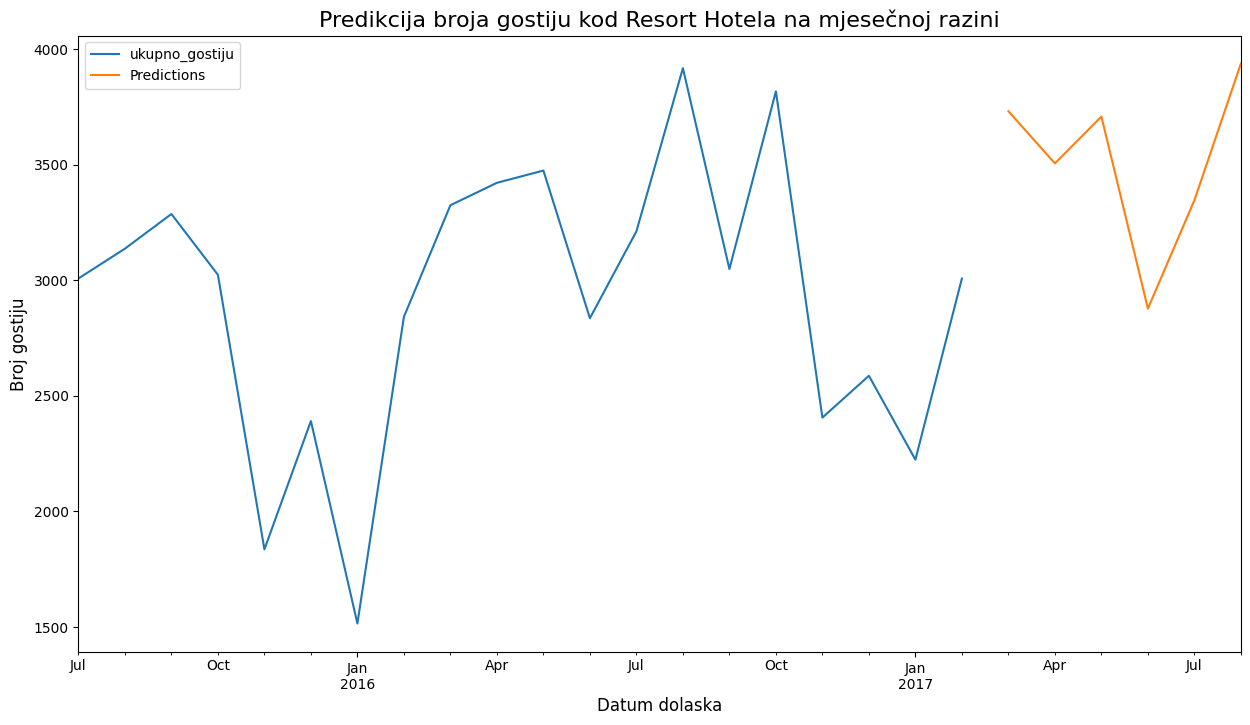

In [206]:
plt.figure(figsize=(15, 8))
trainResortMonthly['ukupno_gostiju'].plot(legend=True)
predictionsResortTestMonthly.plot(legend=True)
plt.title('Predikcija broja gostiju kod Resort Hotela na mjesečnoj razini', fontsize=16)
plt.xlabel('Datum dolaska', fontsize=12)
plt.ylabel('Broj gostiju', fontsize=12)

In [207]:
MeanAbsPercentageErrResortMonthly_test = mean_absolute_percentage_error(testResortMonthly, predictionsResortTestMonthly)
print('Test MAPE Resort Hotel na mjesečnoj razini: %f' % MeanAbsPercentageErrResortMonthly_test)

Test MAPE Resort Hotel na mjesečnoj razini: 0.151461
